## Imports

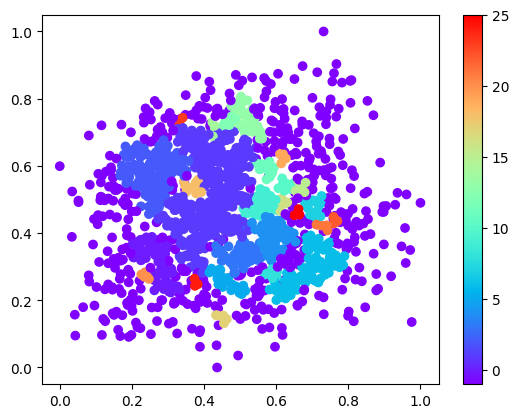

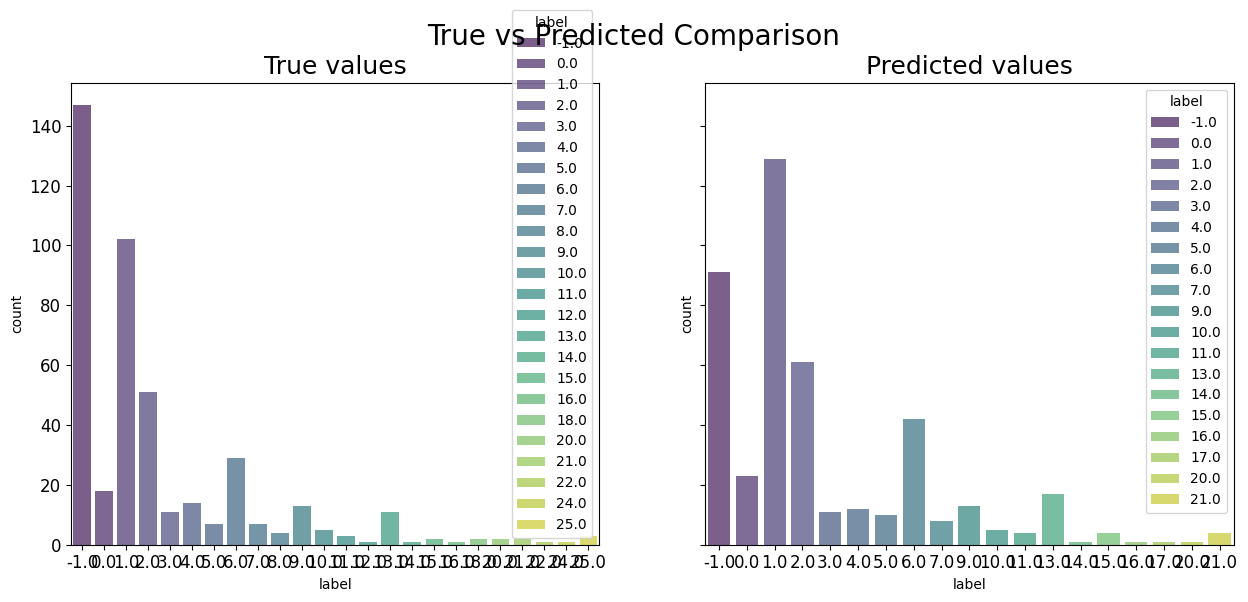

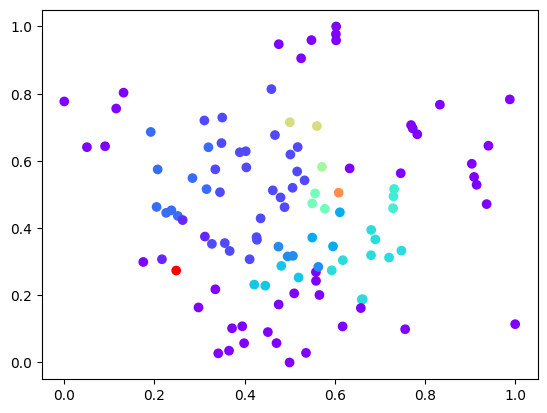

In [22]:
import pandas as pd
import gradio as gr
import nltk
import numpy as np
import matplotlib.pyplot as plt

from machine_learning import MachineLearning

from sklearn.decomposition import PCA
from sklearn import preprocessing

import base64

## Files load

In [23]:
df_descripteur_porter = pd.read_csv('freq_poids_porter.csv')
df_descripteur_lancaster = pd.read_csv('freq_poids_lancaster.csv')

In [24]:
df_freqs_poids_porter = pd.read_csv('freq_poids_porter.csv')
df_freqs_poids_lancaster = pd.read_csv('freq_poids_lancaster.csv')

In [25]:
df_pca_dbscan = pd.read_csv('pca_df_dbscan.csv').drop(['label', 'Unnamed: 0'], axis=1)

In [26]:
queries_porter = pd.read_csv('queries_porter.csv')

In [27]:
ml = MachineLearning()

### Old files (Deprecated)

In [28]:
# df_inverse_porter = pd.read_csv('df_poids.csv').drop('Unnamed: 0', axis=1)
# df_inverse_lancaster = pd.read_csv('df_poids_lan.csv').drop('Unnamed: 0', axis=1)

# Functions

## First tab functions

In [29]:
def search_query_poids(phrase, stemming_method):
        if stemming_method == 'Porter':
                return ml.freq_inverse(df_descripteur_porter, phrase, 'P')
        elif stemming_method == 'Lancaster':
                return ml.freq_inverse(df_descripteur_lancaster, phrase, 'L')

In [30]:
def search_document_number(document, stemming_method):
        if stemming_method == 'Porter':
                new_df = df_descripteur_porter[df_descripteur_porter['Document']== document]
        elif stemming_method == 'Lancaster':
                new_df = df_descripteur_lancaster[df_descripteur_lancaster['Document']== document]
        new_df.drop(['Document'], axis=1, inplace=True)
        return new_df

#### Old functions (deprecated)

In [31]:
# def search_document_descripteur(document, stemming_method):
#         if stemming_method == 'Porter':
#                 new_df = df_descripteur_porter[df_descripteur_porter['Document']== document]
#         elif stemming_method == 'Lancaster':
#                 new_df = df_descripteur_lancaster[df_descripteur_lancaster['Document']== document]
#         new_df.drop(['Document'], axis=1, inplace=True)
        
#         if stemming_method == 'Porter':
#                 inverse = df_inverse_porter.iloc[int(document)].to_frame()
#         elif stemming_method == 'Lancaster':
#                 inverse = df_inverse_lancaster.iloc[int(document)].to_frame()
#         inverse = inverse[(inverse.T != 0.000000).all()]
#         inverse = inverse.reset_index(level=0)
#         inverse["Terme"] = inverse["index"]
#         inverse["Poid"] = inverse[int(document)]
#         inverse.drop([int(document)], axis=1, inplace=True)
#         inverse.drop(['index'], axis=1, inplace=True)

#         return [new_df, inverse]

In [32]:
# def search_document_inverse(phrase, stemming_method):
#         ExpReg = nltk. RegexpTokenizer('(?:[A-Za-z]\.)+|\d+(?:\.\d+)?%?|\w+(?:\-\w+)*')
#         termes = ExpReg.tokenize(phrase)
#         termes = [t.lower() for t in termes]
#         MotsVides = nltk.corpus.stopwords.words('english')
#         if stemming_method == 'Porter':
#                 Porter = nltk.PorterStemmer()
#                 TermesSansMotsVides_p = [Porter.stem(terme) for terme in termes if terme.lower() not in MotsVides]
#         elif stemming_method == 'Lancaster':
#                 Lancaster = nltk.LancasterStemmer()
#                 TermesSansMotsVides_p = [Lancaster.stem(terme) for terme in termes if terme.lower() not in MotsVides]
        
#         if stemming_method == 'Porter':
#                 new_df = df_inverse_porter[TermesSansMotsVides_p]
#         elif stemming_method == 'Lancaster':
#                 new_df = df_inverse_lancaster[TermesSansMotsVides_p]
#         new_df = new_df[(new_df.T != 0.000000).any()]
#         new_df = new_df.reset_index(level=0)

#         if stemming_method == 'Porter':
#                 desc_df = df_descripteur_porter.loc[df_descripteur_porter['Terme'].isin(TermesSansMotsVides_p) ]
#         elif stemming_method == 'Lancaster':
#                 desc_df = df_descripteur_lancaster.loc[df_descripteur_lancaster['Terme'].isin(TermesSansMotsVides_p) ]

#         #new_df.drop(['document'], axis=1, inplace=True)
#         return new_df, desc_df

## Second tab function

In [33]:
def search_query(query, stemmer):
        results = ml.boolean(query, stemmer[0])
        return pd.DataFrame(results)
        

### Test query

In [34]:
# search_query("information AND classification OR NOT title AND computers")

## Third tab functions

In [35]:
def run_dbscan_function(eps, min_samples):
        global X
        X = df_pca_dbscan.copy()
        dbscan = ml.DBSCAN(eps, min_samples, data=df_pca_dbscan.to_numpy())
        dbscan.fit()
        X['label'] = np.nan
        clusters = dbscan.get_clusters()
        noise = dbscan.get_noise()
        for cluster in range (len(clusters)):
                for element in clusters[cluster]:
                        #assign cluster number to each element
                        X.loc[element]['label'] = cluster
        for element in noise:
                #assign cluster number to each element
                X.loc[element]['label'] = -1
        fig,ax = plt.subplots(1,1)
        map = ax.scatter(X['0'],X['1'], c=X['label'], cmap='rainbow')
        fig.colorbar(map, ax=ax)
        res, plot_naive, plot_naive_scatter,confusion_matrix_naive, accuracy, precision, recall, f1 = run_naive_bayes()
        
        return fig, plot_naive, plot_naive_scatter, confusion_matrix_naive, accuracy, precision, recall, f1

In [36]:
def run_naive_bayes():
        pca = PCA(n_components=2)
        pca.fit(queries_porter)
        x_pca = pca.transform(queries_porter)
        pca_df = pd.DataFrame(x_pca)
        x = pca_df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        pca_df_normalized = pd.DataFrame(x_scaled)

        X_train, X_test, y_train, y_test = ml.train_test_split(X, test_size=0.3)
        bayes= ml.NaiveBayesClassifier()
        bayes.fit(X_train, y_train)
        predictions = bayes.predict(X_test.squeeze())
        while (len(np.unique(predictions)) < len(np.unique(X['label']))/2):
            X_train, X_test, y_train, y_test = ml.train_test_split(X, test_size=0.3)
            bayes= ml.NaiveBayesClassifier()
            bayes.fit(X_train, y_train)
            predictions = bayes.predict(X_test.squeeze())

        accuracy = bayes.accuracy(y_test, predictions)

        plot_naive = bayes.visualize(y_test, predictions, 'label')

        pca_df_normalized['label'] = bayes.predict(pca_df_normalized)
        fig2, ax = plt.subplots(1,1)
        ax.scatter(pca_df_normalized[0], pca_df_normalized[1], c=pca_df_normalized['label'], cmap='rainbow')
        
        predictions = pd.Series(predictions)
        y_test.reset_index(drop=True, inplace=True)
        confusion = bayes.confusion_matrix(y_test, predictions)
        precision = pd.DataFrame(bayes.precision(y_test, predictions), columns=['Precision'])
        recall = pd.DataFrame(bayes.recall(y_test, predictions), columns=['Recall'])
        f1 = pd.DataFrame(bayes.f1_score(y_test, predictions), columns=['F1 Score'])
        return bayes, plot_naive, fig2, confusion, accuracy, precision, recall, f1
        

### Test run

In [37]:
# res = run_dbscan_function(0.022221,7)
# type(res[5])

## Fourth Tab Function

In [38]:
def run_evaluation(combo_queries, stemming_method_evaluation, SRI):
        query_idx = combo_queries.split(':')[0]
        
        output = ml.roc_curve(stemming_method_evaluation[0], int(query_idx), SRI)
        res = output[0]
        cm = pd.DataFrame(output[1],columns=['Pertinent','Non Pertinent'],index=['Pertinent','Non Pertinent'])
        # roc_curve, top10, p5, p10, p5_inter, p10_inter
        fig, ax = plt.subplots(1,1)
        ax.plot(res['Rappel_Interpolée'], res['Precision_Interpolée'])
        return fig, res, res['Precision'].iloc[4], res['Precision'].iloc[9], res['Precision_Interpolée'].iloc[4], res['Precision_Interpolée'].iloc[9], cm

### Test

In [39]:
# run_evaluation('5: zdodifjkz', 'Porter', 'Datamining')

# Main

### Additional

In [40]:
queries = list(ml.qry_set.items())
queries[:] = [f"{elem[0]}: "+elem[1][:50] +"..." for elem in queries]


### Gradio app

In [41]:
with gr.Blocks() as app:
        gr.Markdown("main app")
        with gr.Tab("Main Searches"):
                with gr.Row():
                        with gr.Column():
                                gr.Markdown("Search by Term")
                                search_input = gr.Textbox(label="Search for terms")
                                
                with gr.Row():
                        with gr.Column():
                                gr.Markdown("Search by Document")
                                search_document = gr.Number()
                        with gr.Column():
                                gr.Markdown("Stemming method")
                                stemming_method = gr.Radio(["Porter", "Lancaster"], label="Stemming")
                with gr.Row():
                        with gr.Column():
                                search_document_button = gr.Button(value="Search by Document")
                        with gr.Column():
                                search_button = gr.Button(value="Search by Term")
                with gr.Row():
                        search_output = gr.Numpy()

        with gr.Tab("Boolean Search"):
                gr.Markdown("Boolean Search")
                search_boolean = gr.Textbox(label="Boolean search")
                stemmer_boolean = gr.Radio(["Porter", "Lancaster"], label="Stemming")
                search_boolean_button = gr.Button(value="Search")
                search_boolean_output = gr.Numpy()
        with gr.Tab("DBScan"):
                gr.Markdown("DBScan")
                with gr.Row():
                        with gr.Column():
                                plot_dbscan = gr.Plot()
                        with gr.Column():
                                eps = gr.Number(label="Eps")
                                min_samples = gr.Number(label="Min Samples")
                                run_dbscan = gr.Button(value="Run DBScan")
        with gr.Tab("Naive Bayes"):
                gr.Markdown("Naive Bayes")
                plot_naive = gr.Plot()
                with gr.Row():
                        with gr.Column():
                                plot_naive_scatter = gr.Plot()
                        with gr.Column():
                                accuracy = gr.Textbox(label = 'Accuracy')
                with gr.Row():
                        with gr.Column():
                                precision = gr.Numpy()
                        with gr.Column():
                                recall = gr.Numpy()
                        with gr.Column():
                                f1 = gr.Numpy()
                with gr.Row():
                        confusion_matrix_naive = gr.Numpy()
                
        with gr.Tab("Evaluation"):
                gr.Markdown("Evaluation")
                with gr.Row():
                        with gr.Column():
                                roc_curve = gr.Plot()
                                run_eval = gr.Button(value="Run Evaluation")
                        with gr.Column():
                                combo_queries = gr.Dropdown(queries)
                                with gr.Row():
                                        stemming_method_evaluation = gr.Radio(["Porter", "Lancaster"], label="Stemming")
                                with gr.Row():
                                        SRI = gr.Radio(["Cosine", "Jaccard", "BM25", "Produit Scalaire", "Datamining"], label = "SRI")
                with gr.Row():
                        top10 = gr.Numpy()
                with gr.Row():
                        with gr.Column():
                                p5 = gr.Textbox(label = 'p@5')
                                p10 = gr.Textbox(label = 'p@10')
                        with gr.Column():
                                p5_inter = gr.Textbox(label = 'p@5 interpolée')
                                p10_inter = gr.Textbox(label = 'p@10_interpolée')
                with gr.Row():
                        eval_matrix = gr.Numpy()


        search_button.click(search_query_poids, inputs = [search_input, stemming_method], outputs = search_output)
        search_document_button.click(search_document_number, inputs = [search_document, stemming_method], outputs = search_output)
        search_boolean_button.click(search_query, inputs = [search_boolean, stemmer_boolean], outputs = search_boolean_output)
        run_dbscan.click(run_dbscan_function, inputs = [eps, min_samples], outputs = [plot_dbscan, plot_naive, plot_naive_scatter, confusion_matrix_naive, accuracy, precision, recall, f1])
        run_eval.click(run_evaluation, inputs = [combo_queries, stemming_method_evaluation, SRI], outputs = [roc_curve, top10, p5, p10, p5_inter, p10_inter, eval_matrix])
        

app.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
